# Поиск аномалий в сетевом трафике

### Подключение необходимых библиотек

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score

### Загрузка данных из файла в DataFrame

In [57]:

df = pd.read_csv('1000_first_sessions.csv')

In [58]:
df.head()

,session_id,date_time,source_ip,source_port,destination_ip,destination_port,bytes,packages_count
0,6.421055e+13,2022-04-20 15:03:27.404,10.174.174.236,52263,10.253.252.11,9400,523,5
1,6.421055e+13,2022-04-20 15:03:27.405,10.253.252.11,9400,10.174.174.236,52263,1523,3
2,6.421055e+13,2022-04-20 15:05:07.482,10.174.174.236,52263,10.253.252.11,9400,40,2
3,6.421055e+13,2022-04-20 15:05:07.482,10.253.252.11,9400,10.174.174.236,52263,20,1
4,6.421055e+13,2022-04-20 15:05:27.734,10.174.174.236,52302,10.253.252.11,9400,503,4


In [59]:
df.dtypes

session_id          float64
date_time            object
source_ip            object
source_port           int64
destination_ip       object
destination_port      int64
bytes                 int64
packages_count        int64
dtype: object

### Поиск пропусков

In [60]:
def draw_missing(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)*100
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent of missing data'])
    return missing_data

draw_missing(df)

,Total,Percent of missing data
session_id,0,0.0
date_time,0,0.0
source_ip,0,0.0
source_port,0,0.0
destination_ip,0,0.0
destination_port,0,0.0
bytes,0,0.0
packages_count,0,0.0


### Удаление столбцов, которые не будут использоваться

In [61]:
df.drop(['session_id', 'date_time'], axis=1, inplace=True)

### Нормализация данных

In [62]:
le_source_ip = LabelEncoder()
le_destination_ip = LabelEncoder()
le_source_port = LabelEncoder()
le_destination_port = LabelEncoder()

In [63]:
df['source_ip'] = le_source_ip.fit_transform(df['source_ip'])
df['destination_ip'] = le_destination_ip.fit_transform(df['destination_ip'])
df['source_port'] = le_source_port.fit_transform(df['source_port'])
df['destination_port'] = le_destination_port.fit_transform(df['destination_port'])

In [64]:
scaler = StandardScaler()
df[['source_ip', 'destination_ip', 'source_port', 'destination_port', 'bytes', 'packages_count']] = scaler.fit_transform(df[['source_ip', 'destination_ip', 'source_port', 'destination_port', 'bytes', 'packages_count']])

### Создание экземпляра класса DBSCAN и использование закодированных и нормализованных значений для кластеризации

In [73]:
dbscan = DBSCAN(eps=0.5, min_samples=4)
X = df[['source_ip', 'destination_ip', 'source_port', 'destination_port', 'bytes', 'packages_count']]
clusters = dbscan.fit_predict(X)

### Добавление меток кластеров в исходный датафрейм

In [74]:
df['cluster'] = clusters

### Обнаружение аномалий

In [75]:
labels = dbscan.labels_
df['is_anomaly'] = np.where(labels==-1, 1, 0)

### Разбивка данных на обучающую и тестовую выборки

In [76]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['is_anomaly'], axis=1), df['is_anomaly'], test_size=0.3, random_state=42, stratify=df['is_anomaly'])

### Создание экземпляра модели градиентного бустинга с регуляризацией

In [69]:
gb = GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.8, random_state=42, min_samples_split=10, min_samples_leaf=5, max_features='sqrt')

gb.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=5, max_features='sqrt', min_samples_leaf=5,
                           min_samples_split=10, random_state=42,
                           subsample=0.8)

### Получение прогноза для тестовых данных и вычисление метрик производительности

In [77]:
y_pred = gb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

### Вывод значений метрик

In [78]:
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.9997731568998109
Precision: 1.0
Recall: 0.9482758620689655
F1 Score: 0.9734513274336283


### Группировка точек по кластерам и вывод результатов на графике

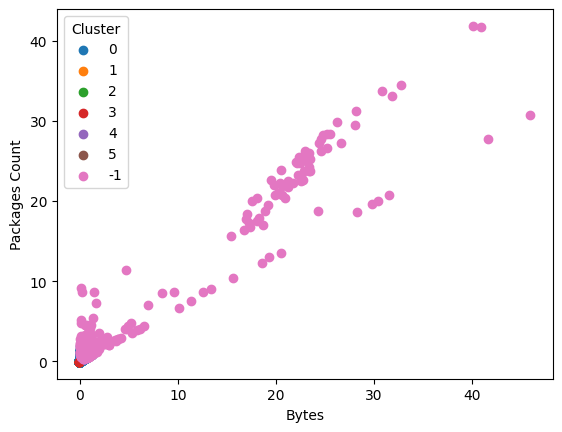

In [79]:
fig, ax = plt.subplots()

for i in set(clusters):
    mask = (clusters == i)
    ax.scatter(X[mask]['bytes'], X[mask]['packages_count'], label=i)

ax.set_xlabel('Bytes')
ax.set_ylabel('Packages Count')
ax.legend(title='Cluster')
plt.show()